In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
data_dict = {"$CPI$":"CPIAUCNS",
             "MB": "BOGMBASE",
             "UST10Y": "DGS10",
             "NGDP":"GDP",
             "Currency":"CURRCIR",
             "FRAssets":"WALCL",
             "EFFR": "DFF"}

freq = "Q"
start = datetime.datetime(1950, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

data = gather_data(data_dict, start, 
          end = end, freq = freq)
# df["Nominal GDP"] = df["Nominal GDP"].mul(1000)
# df["Real GDP"] = df["Real GDP"].mul(1000)

In [3]:
freq = 4 * 1
keys = data.keys()
annual_rate = data.copy()
quarterly_rate = data.copy()
for key in keys:
#     if "PPI" in key or "CPI" in key or "M2" in key:
    annual_rate[key] = data[key].pct_change(freq ) * 100
    quarterly_rate[key] = ((data[key].pct_change(1)).add(1)).pow(freq ).sub(1).mul(100)

for key in keys:
    if "Rate" in key or "UST" in key:
        annual_rate[key] = data[key]
        quarterly_rate[key] = data[key]
        
diff_annual_rate = annual_rate.diff(freq)

In [4]:
annual_rate

,$CPI$,MB,UST10Y,NGDP,Currency,FRAssets,EFFR
DATE,,,,,,,
1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951-03-31,8.923513,NaN,NaN,19.646189,0.429427,NaN,NaN
...,...,...,...,...,...,...,...
2021-06-30,4.848945,20.771401,1.590781,16.755356,12.630916,16.984461,16.074766
2021-09-30,5.335693,30.995969,1.324844,9.763052,9.310941,18.769083,-2.816901
2021-12-31,6.689105,25.775140,1.533387,11.757451,7.645499,19.527117,-10.526316


,$CPI$,MB,UST10Y,NGDP,Currency,FRAssets,EFFR
$CPI$,1.000000,-0.314464,0.380970,0.209856,-0.218470,-0.605873,0.156830
MB,-0.314464,1.000000,-0.108926,-0.400855,0.600015,0.933441,-0.357538
UST10Y,0.380970,-0.108926,1.000000,0.253076,-0.052192,-0.326866,0.155018
NGDP,0.209856,-0.400855,0.253076,1.000000,-0.083761,-0.639053,0.290161
Currency,-0.218470,0.600015,-0.052192,-0.083761,1.000000,0.743862,-0.156653
FRAssets,-0.605873,0.933441,-0.326866,-0.639053,0.743862,1.000000,-0.295474
EFFR,0.156830,-0.357538,0.155018,0.290161,-0.156653,-0.295474,1.000000


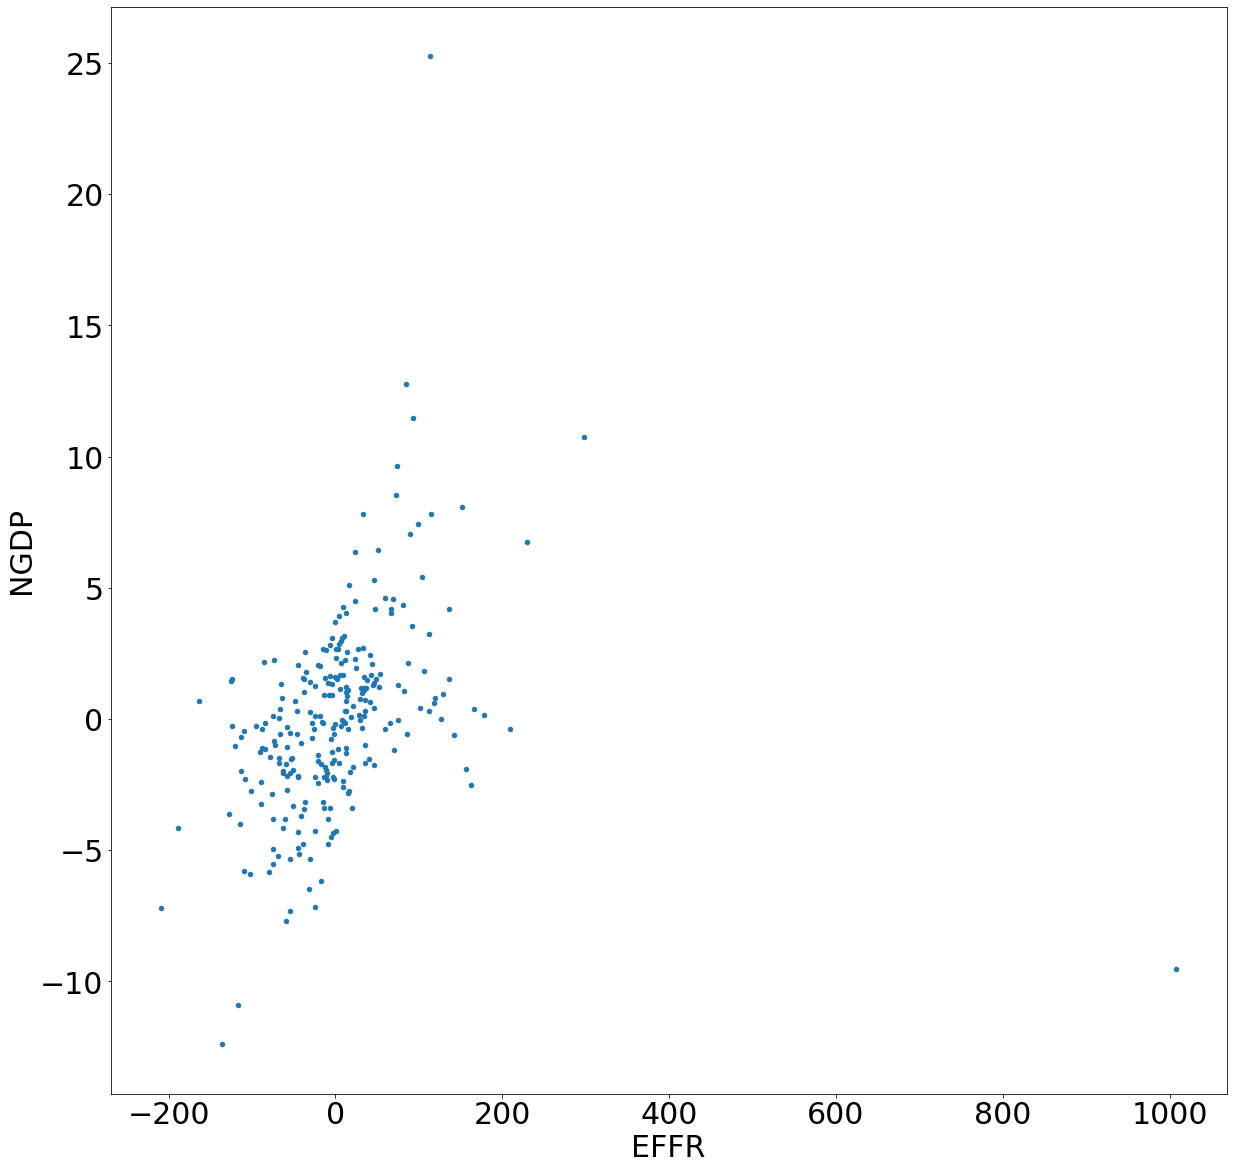

In [5]:
plt.rcParams.update({"font.size":30})
fig, ax = plt.subplots(figsize = (20,20))
annual_rate.diff(freq).plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
annual_rate.diff(freq).corr()

In [6]:
def build_smooth_multiple_regression_estimator(reg, orig_df):
    def find_between_from_list(lst, start, end):
        for i in range(len(lst)):
            s = lst[i]
            if start in s and end in s:
                lst[i] = (s.split(start))[1].split(end)[0]
        return lst    
    results = reg.fit()
    df = reg.data.frame
    orig_names =  find_between_from_list(list(reg.data.orig_endog.keys()) + list(reg.data.orig_exog.keys()), "(", ")")
    y_var, X_vars = orig_names[0], orig_names[1:]
    X_vars = [x for x in X_vars if x != "Intercept" and x in df.keys()]
    for x_name in X_vars:
        x_min, x_max = df[x_name].describe()[["min","max"]]
        X = pd.DataFrame({x_name: np.linspace(x_min, x_max, num = 1000)})
        keys = [x for x in X_vars if x != x_name]
        X[keys] = df[keys].mean()
        lpr_PICI = results.get_prediction(X).summary_frame(alpha = 0.05)
        lpr_PICI.index = X[x_name]
        lpr_CI = lpr_PICI[["mean", "mean_ci_lower", "mean_ci_upper"]]
        fig, ax = plt.subplots(figsize = (20,10))
        for key in lpr_CI:
            ls, alpha = ("--", .5) if "ci" in key else ("-", 1)
            lpr_CI[[key]].plot(ls = ls, 
                               linewidth = 3, 
                               alpha = alpha, color = "C0", ax = ax)
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_var)
        scatter_df = df.copy()
        orig_yname =  list(reg.data.orig_endog.keys())[0]
        orig_y = reg.data.orig_endog[orig_yname]
        scatter_df[y_var] = orig_y
        scatter_df.groupby(x_name).mean()[y_var].reset_index().plot.scatter(x = x_name, y = y_var, 
                                                                                ax = ax, color = "k", alpha = .75)

In [7]:
annual_rate

,$CPI$,MB,UST10Y,NGDP,Currency,FRAssets,EFFR
DATE,,,,,,,
1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951-03-31,8.923513,NaN,NaN,19.646189,0.429427,NaN,NaN
...,...,...,...,...,...,...,...
2021-06-30,4.848945,20.771401,1.590781,16.755356,12.630916,16.984461,16.074766
2021-09-30,5.335693,30.995969,1.324844,9.763052,9.310941,18.769083,-2.816901
2021-12-31,6.689105,25.775140,1.533387,11.757451,7.645499,19.527117,-10.526316


                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     45.55
Date:                Sat, 16 Jul 2022   Prob (F-statistic):           1.18e-32
Time:                        18:27:34   Log-Likelihood:                -559.52
No. Observations:                 238   AIC:                             1131.
Df Residuals:                     232   BIC:                             1152.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0497      0.167      0.297      0.7

,NGDP,EFFR,UST10Y,Currency,MB,NGDPLag1
NGDP,1.000000,0.283793,0.259236,0.087384,-0.264952,-0.569526
EFFR,0.283793,1.000000,0.022283,0.079359,-0.236896,0.316947
UST10Y,0.259236,0.022283,1.000000,-0.002534,0.005692,0.200743
Currency,0.087384,0.079359,-0.002534,1.000000,0.622901,-0.098810
MB,-0.264952,-0.236896,0.005692,0.622901,1.000000,0.006375
NGDPLag1,-0.569526,0.316947,0.200743,-0.098810,0.006375,1.000000


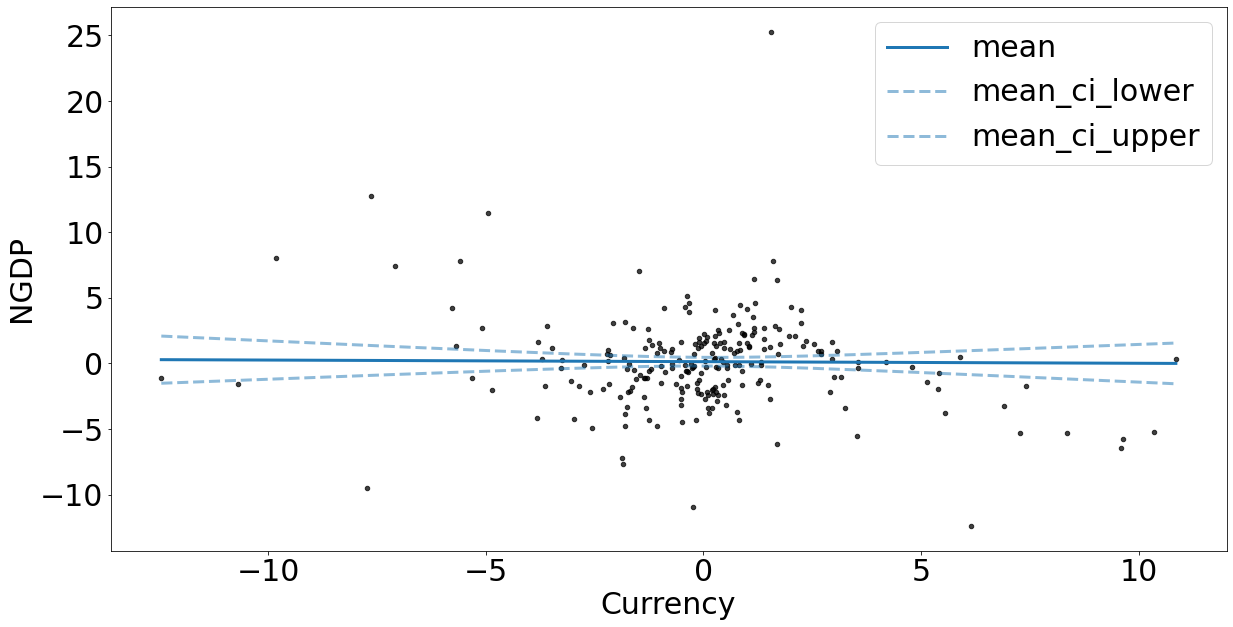

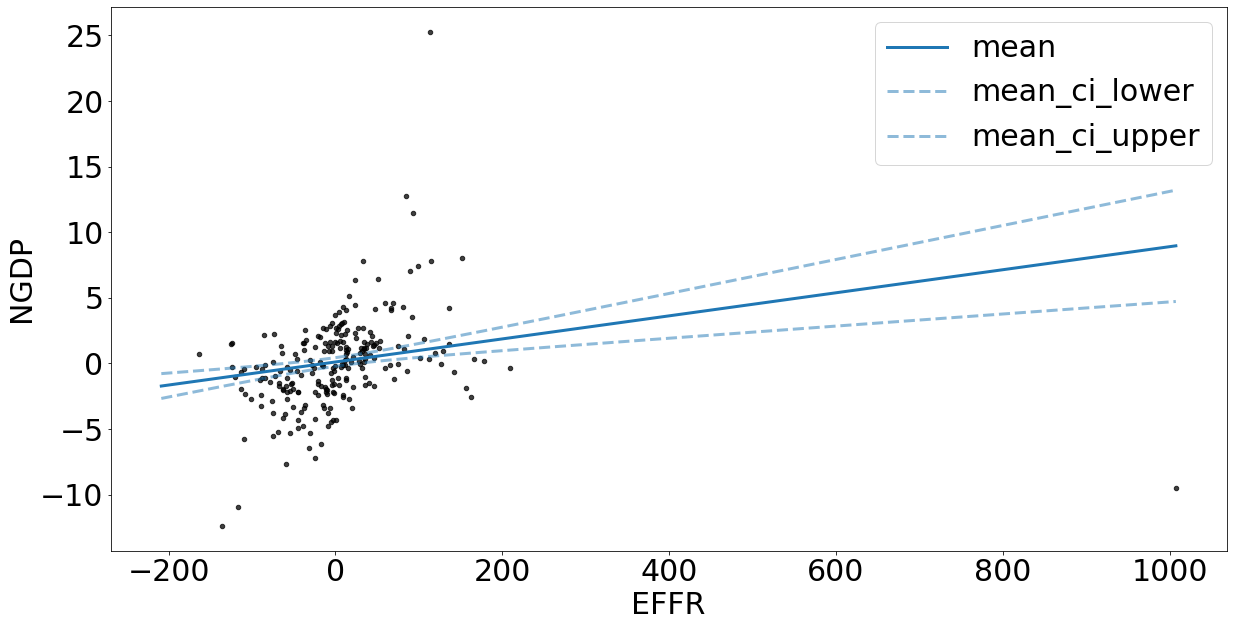

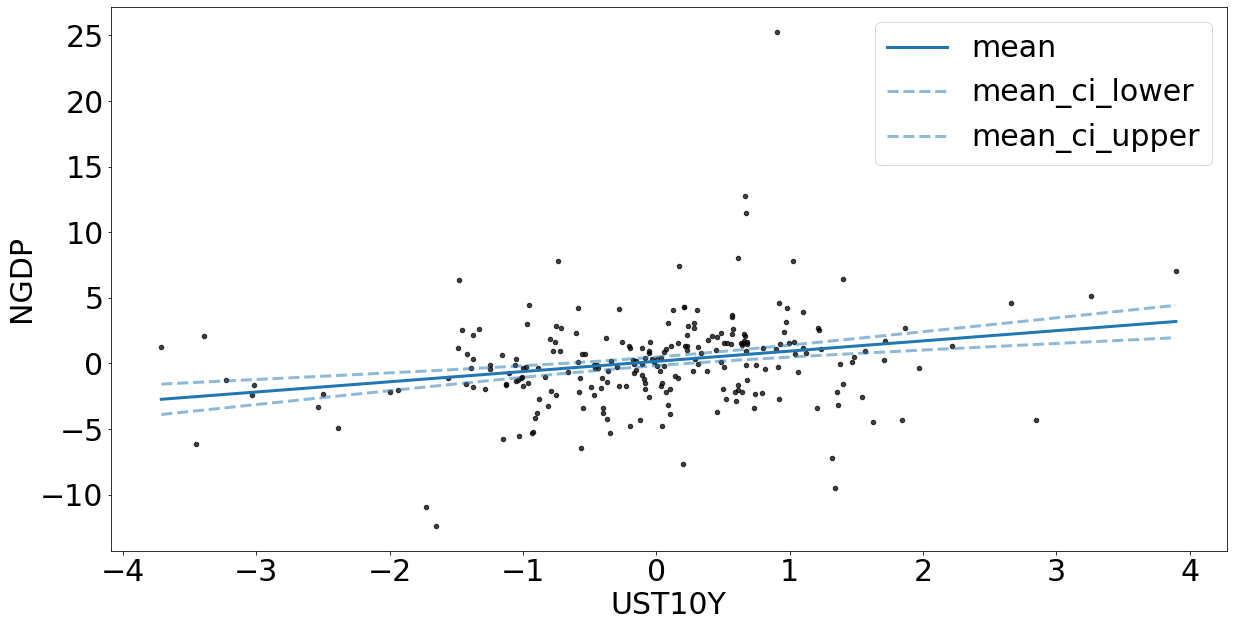

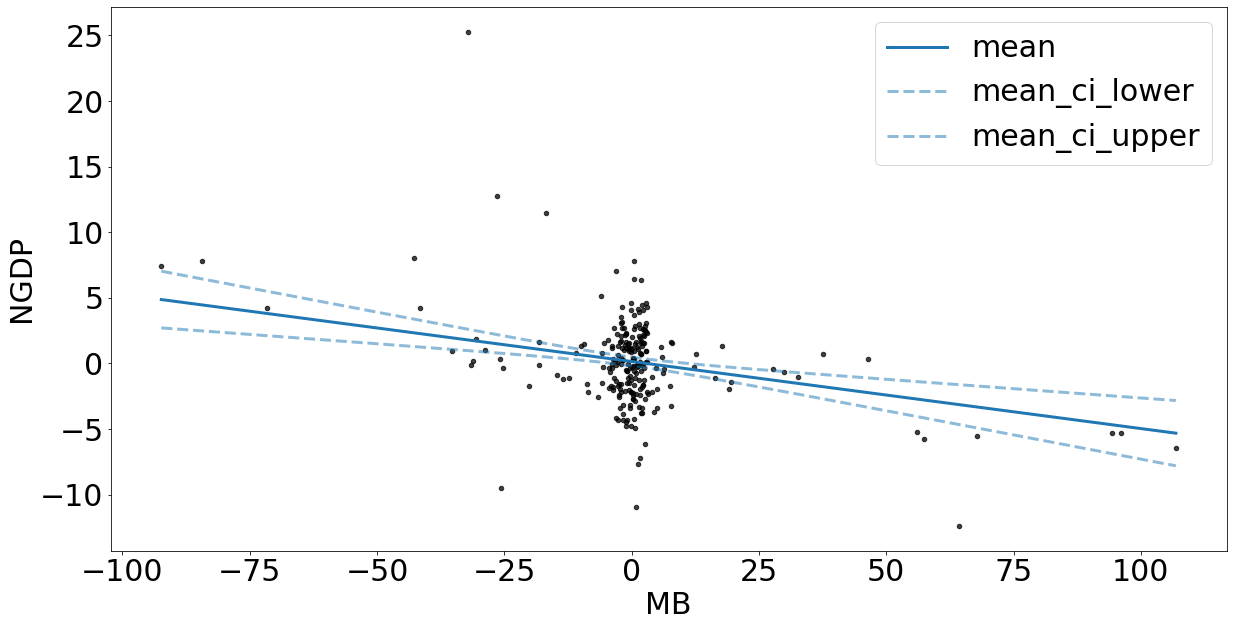

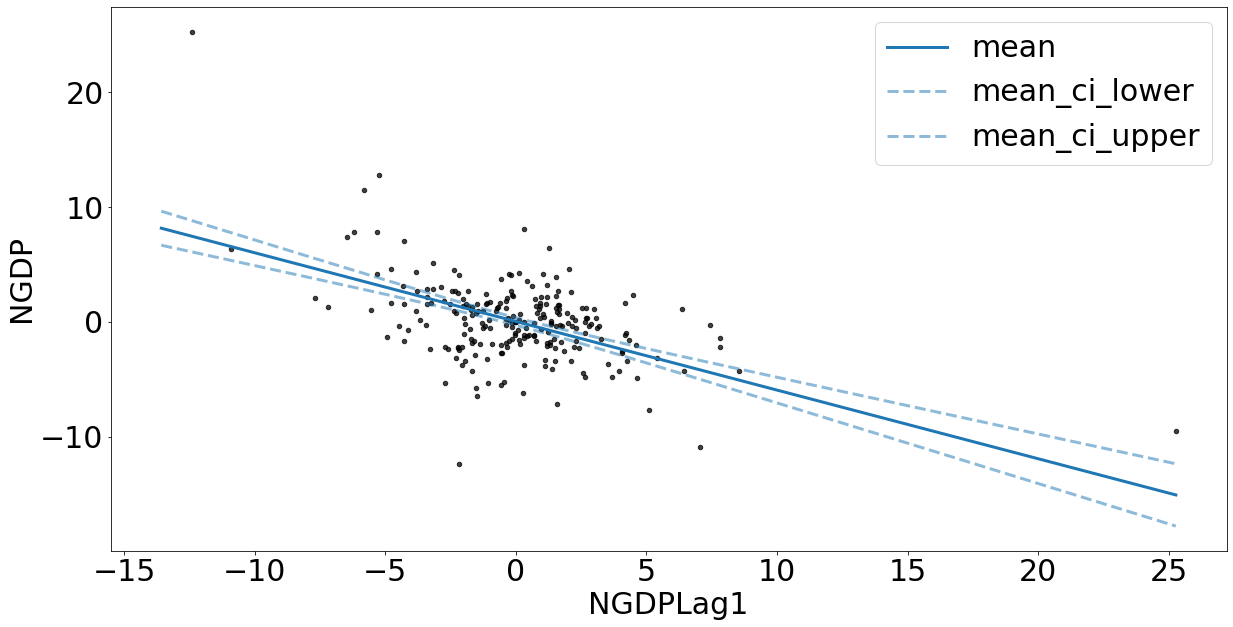

In [8]:
# fig, ax = plt.subplots(figsize = (20,20))
lags = 1
plot_vars = ["NGDP",  "EFFR", "UST10Y", "Currency", "MB"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = annual_rate.diff(freq)[plot_vars]#.loc[:"2003"]
formula = 'NGDP ~  Currency + EFFR + UST10Y + MB'
for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 

# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()



                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     37.76
Date:                Sat, 16 Jul 2022   Prob (F-statistic):           2.35e-25
Time:                        18:27:35   Log-Likelihood:                -341.07
No. Observations:                 164   AIC:                             694.1
Df Residuals:                     158   BIC:                             712.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0049      0.154     -0.032      0.9

,NGDP,EFFR,UST10Y,Currency,MB,NGDPLag1
NGDP,1.000000,0.519102,0.179720,-0.047028,0.048010,-0.506556
EFFR,0.519102,1.000000,0.047164,0.139157,-0.055520,0.153735
UST10Y,0.179720,0.047164,1.000000,0.332796,-0.379164,0.230863
Currency,-0.047028,0.139157,0.332796,1.000000,0.779134,-0.173742
MB,0.048010,-0.055520,-0.379164,0.779134,1.000000,0.134327
NGDPLag1,-0.506556,0.153735,0.230863,-0.173742,0.134327,1.000000


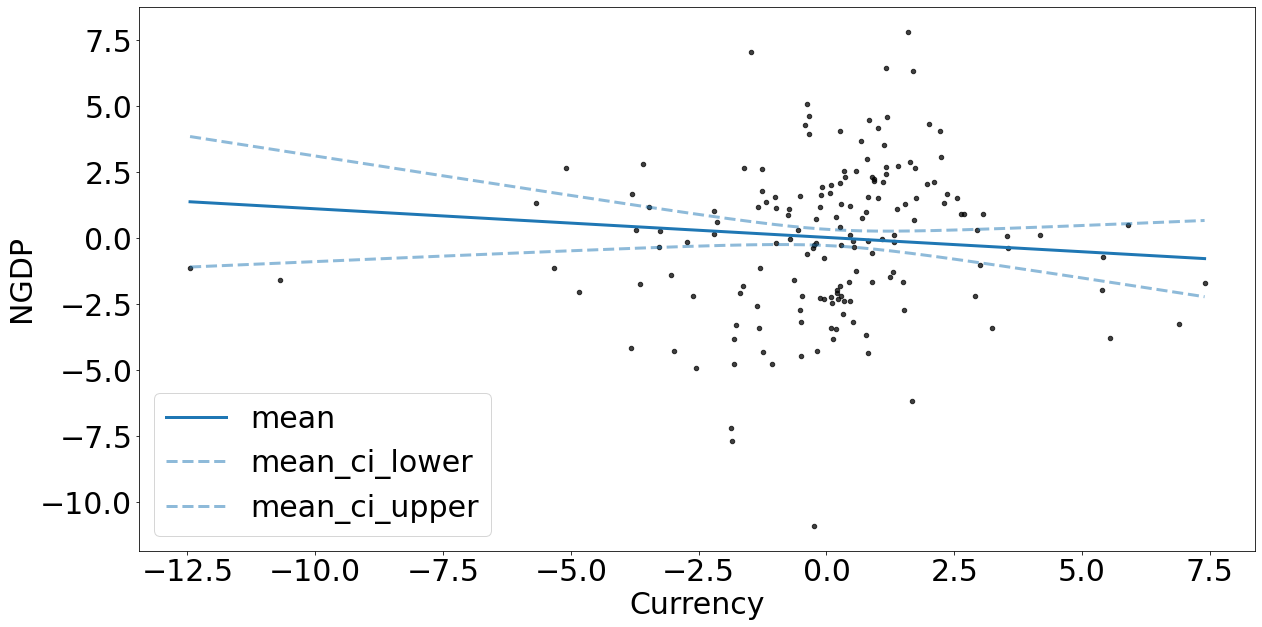

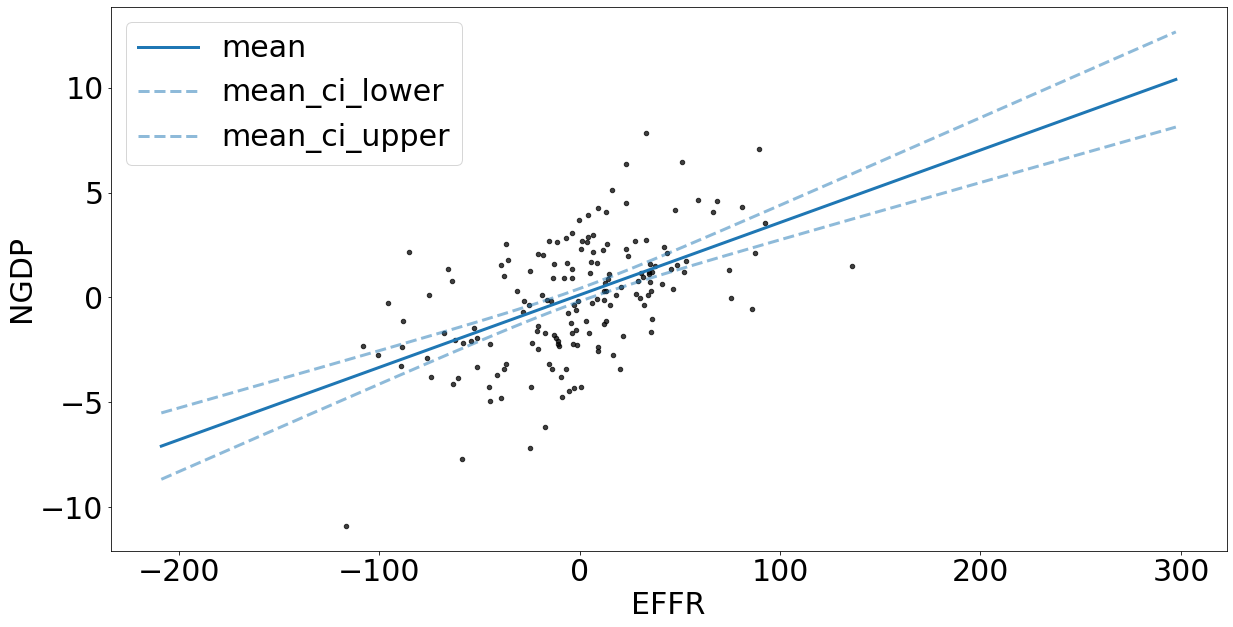

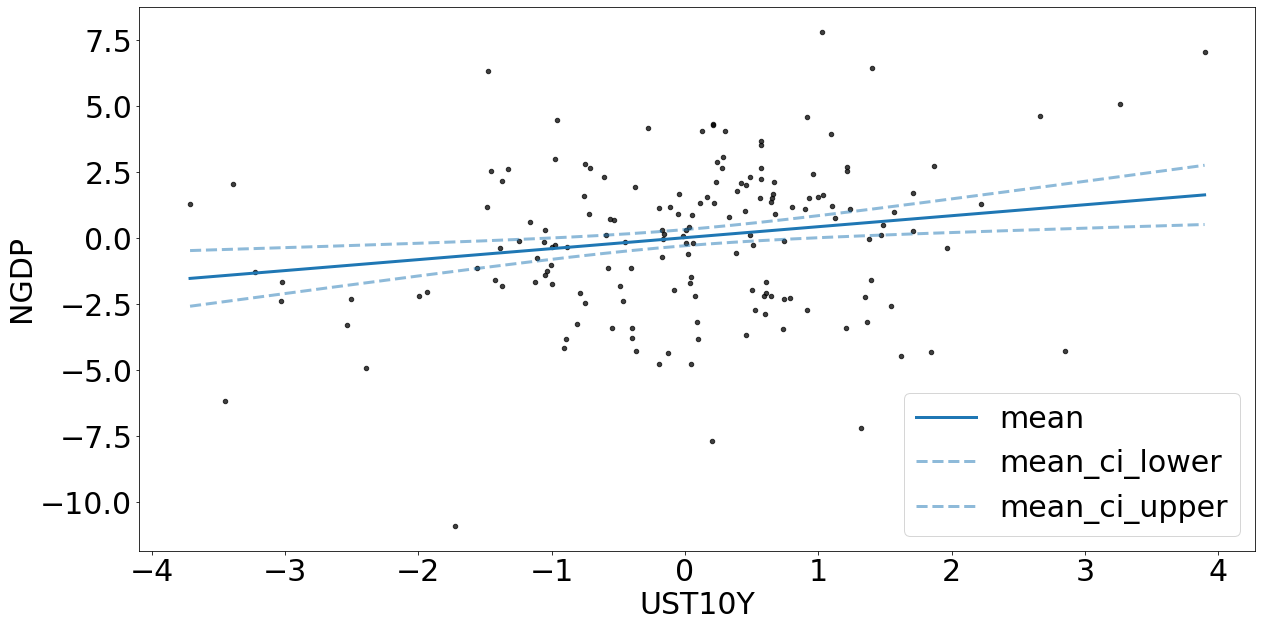

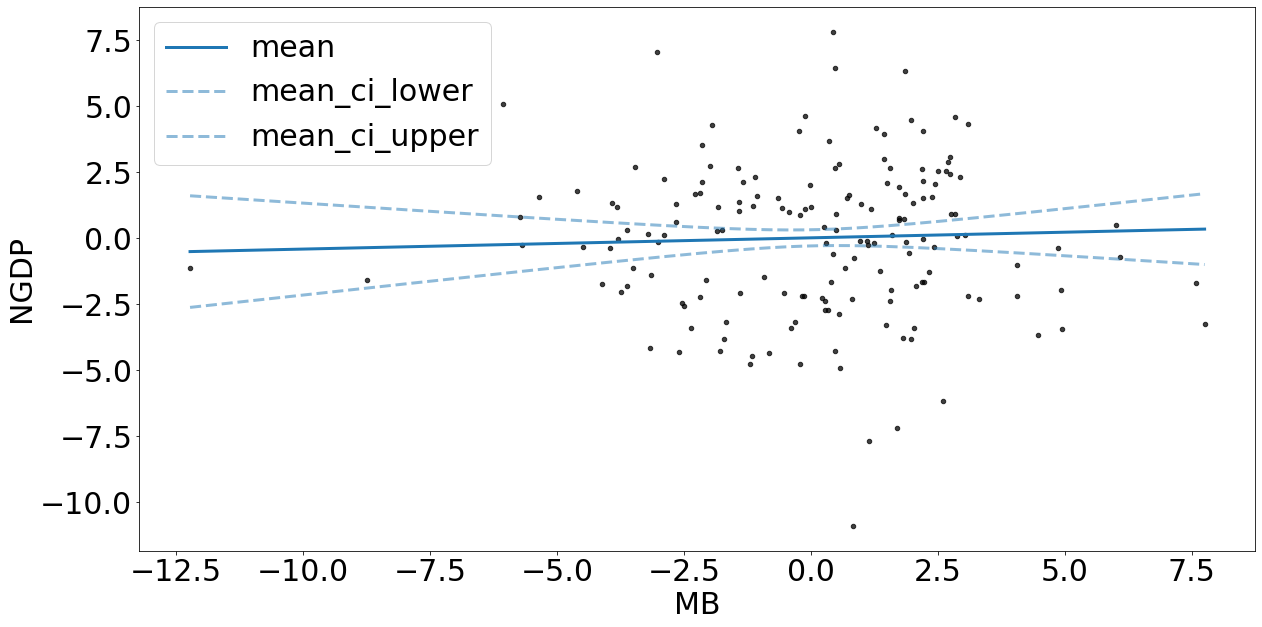

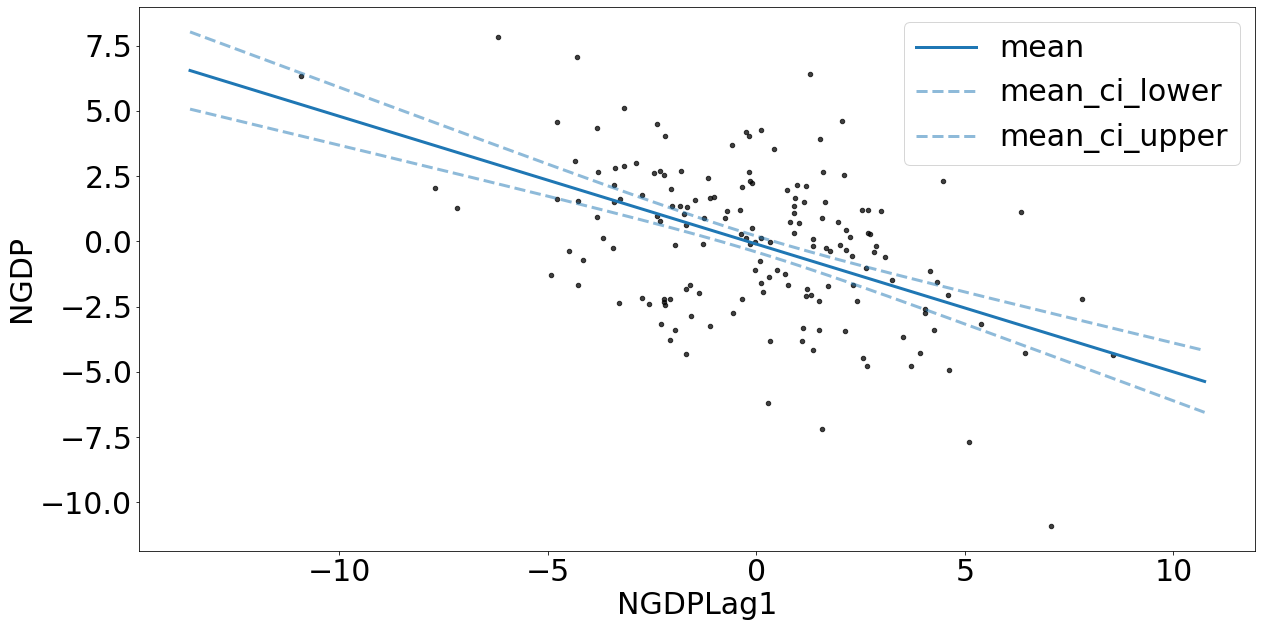

In [9]:
# fig, ax = plt.subplots(figsize = (20,20))
plot_vars = ["NGDP",  "EFFR", "UST10Y", "Currency", "MB"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = annual_rate.diff(freq)[plot_vars].loc[:"2003"]
formula = 'NGDP ~  Currency + EFFR + UST10Y + MB'
for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 
# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()


                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     19.02
Date:                Sat, 16 Jul 2022   Prob (F-statistic):           2.90e-12
Time:                        18:27:36   Log-Likelihood:                -167.08
No. Observations:                  67   AIC:                             348.2
Df Residuals:                      60   BIC:                             363.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3718      0.389      0.956      0.3

,NGDP,EFFR,UST10Y,Currency,MB,FRAssets,NGDPLag1
NGDP,1.000000,0.177619,0.419164,0.105768,-0.132357,-0.127236,-0.601390
EFFR,0.177619,1.000000,0.001551,-0.070322,-0.231496,0.131376,0.498816
UST10Y,0.419164,0.001551,1.000000,-0.308427,0.311095,-0.186943,0.304240
Currency,0.105768,-0.070322,-0.308427,1.000000,0.253193,0.144962,-0.037224
MB,-0.132357,-0.231496,0.311095,0.253193,1.000000,0.824415,-0.145367
FRAssets,-0.127236,0.131376,-0.186943,0.144962,0.824415,1.000000,0.146311
NGDPLag1,-0.601390,0.498816,0.304240,-0.037224,-0.145367,0.146311,1.000000


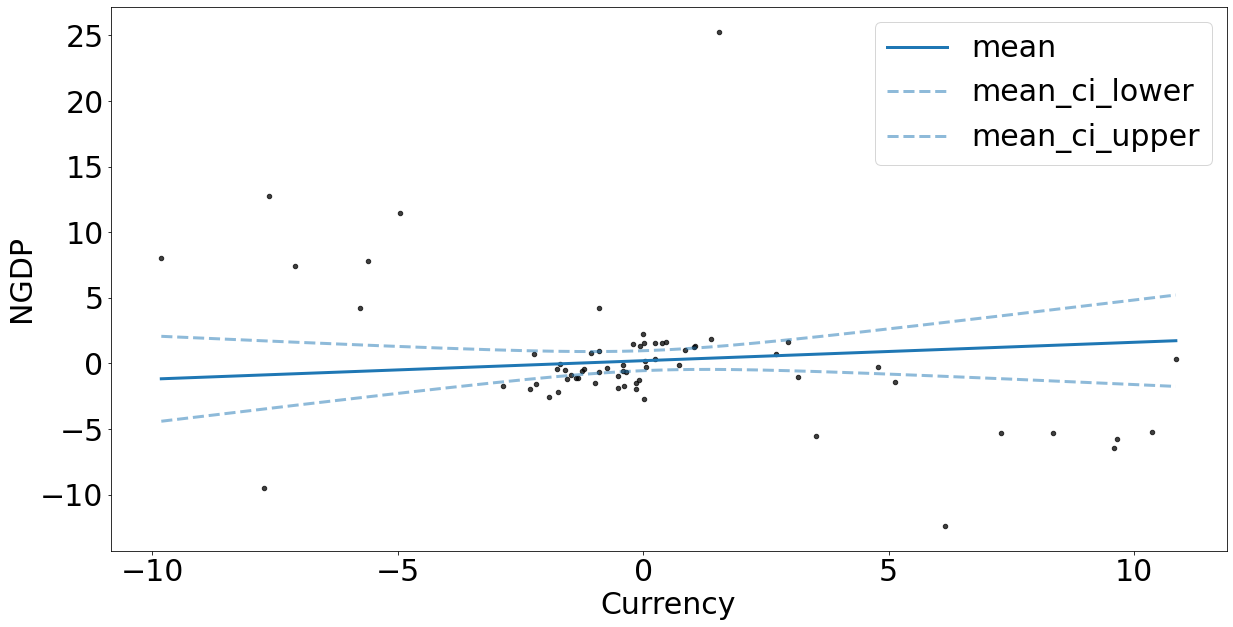

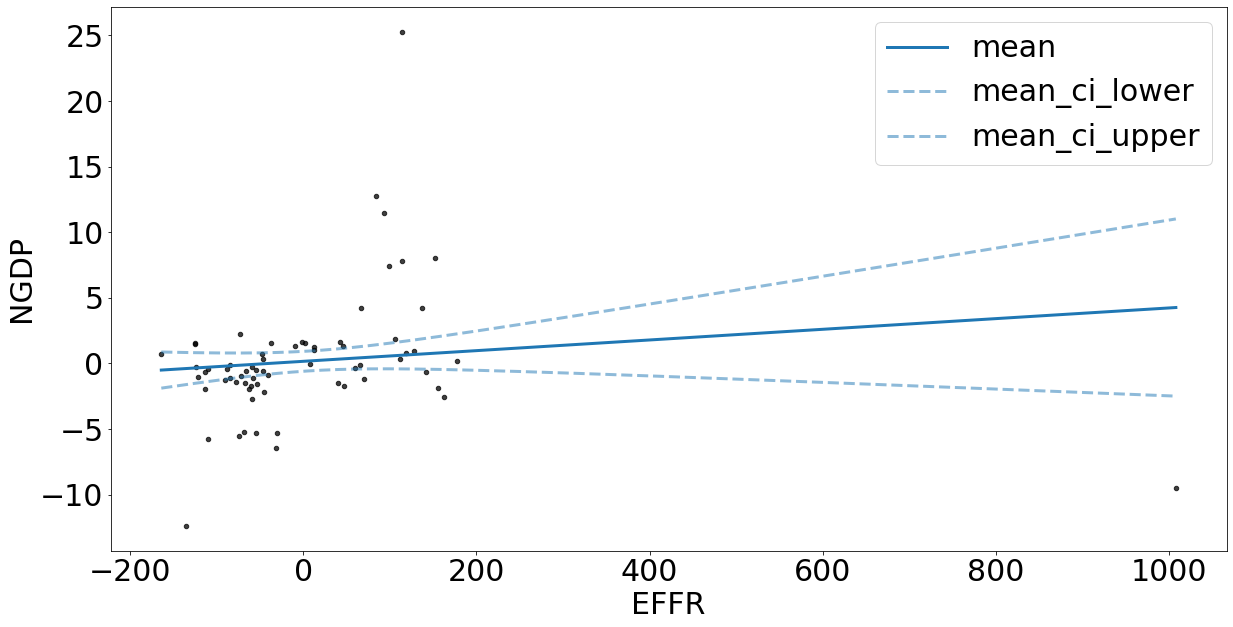

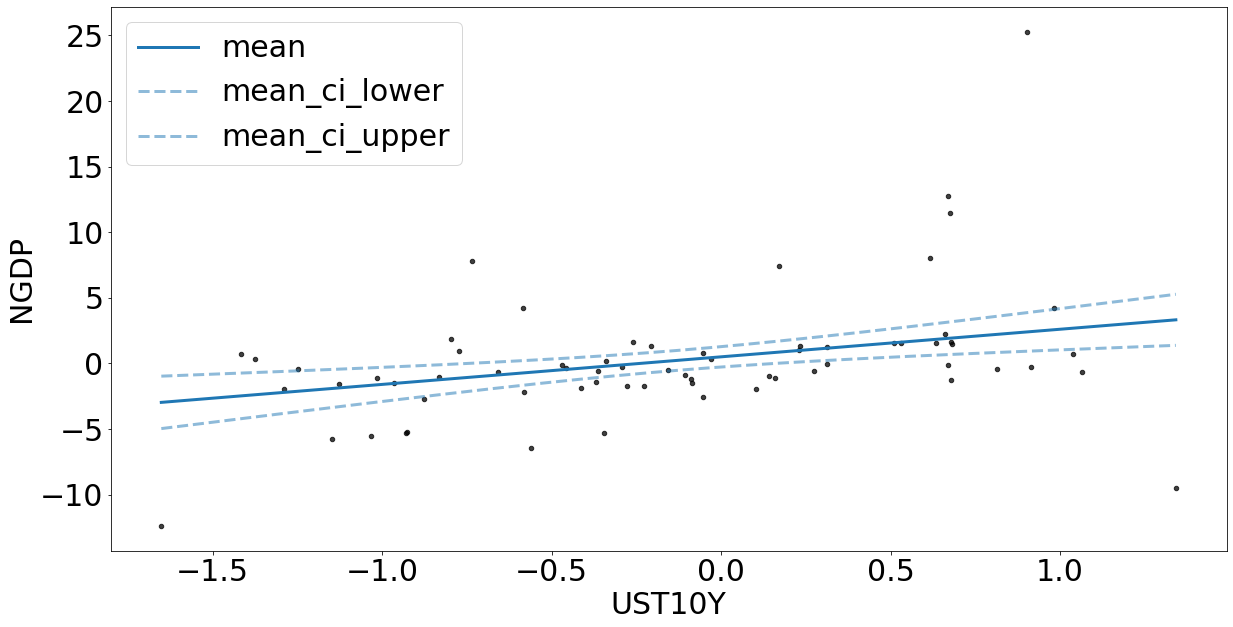

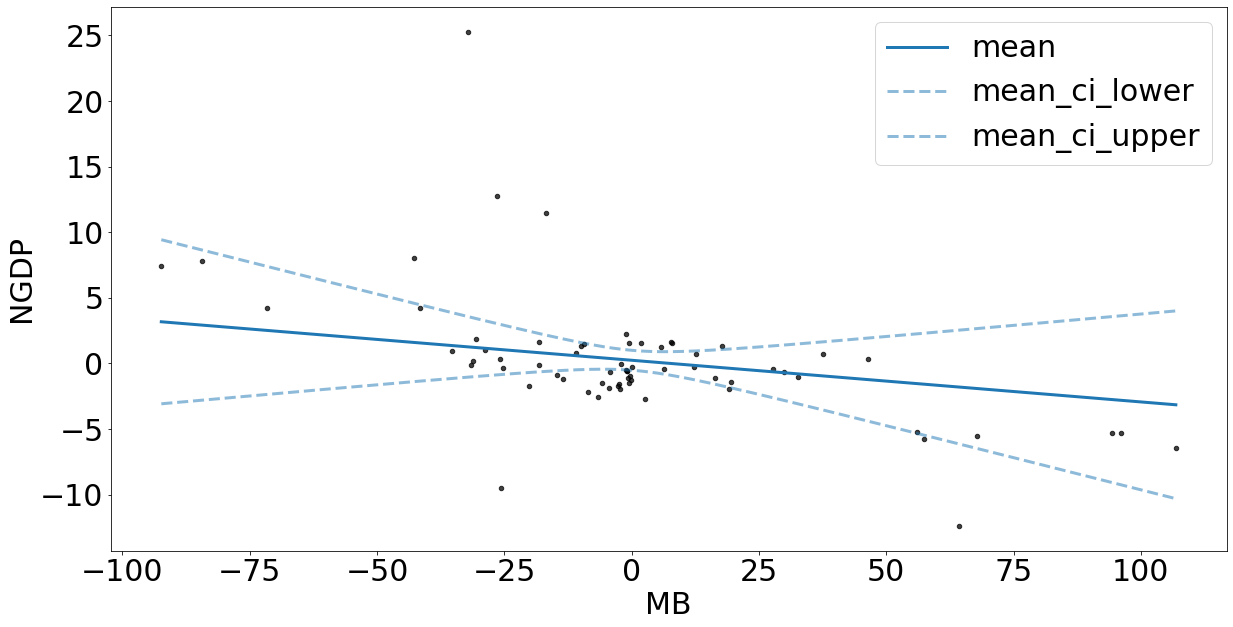

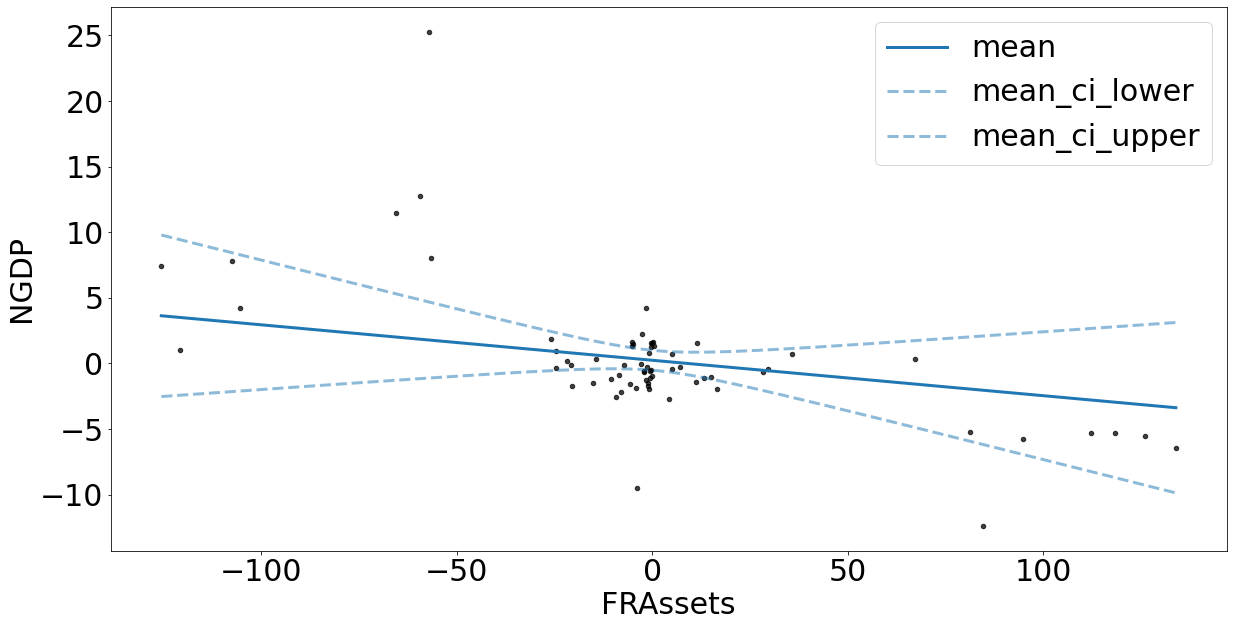

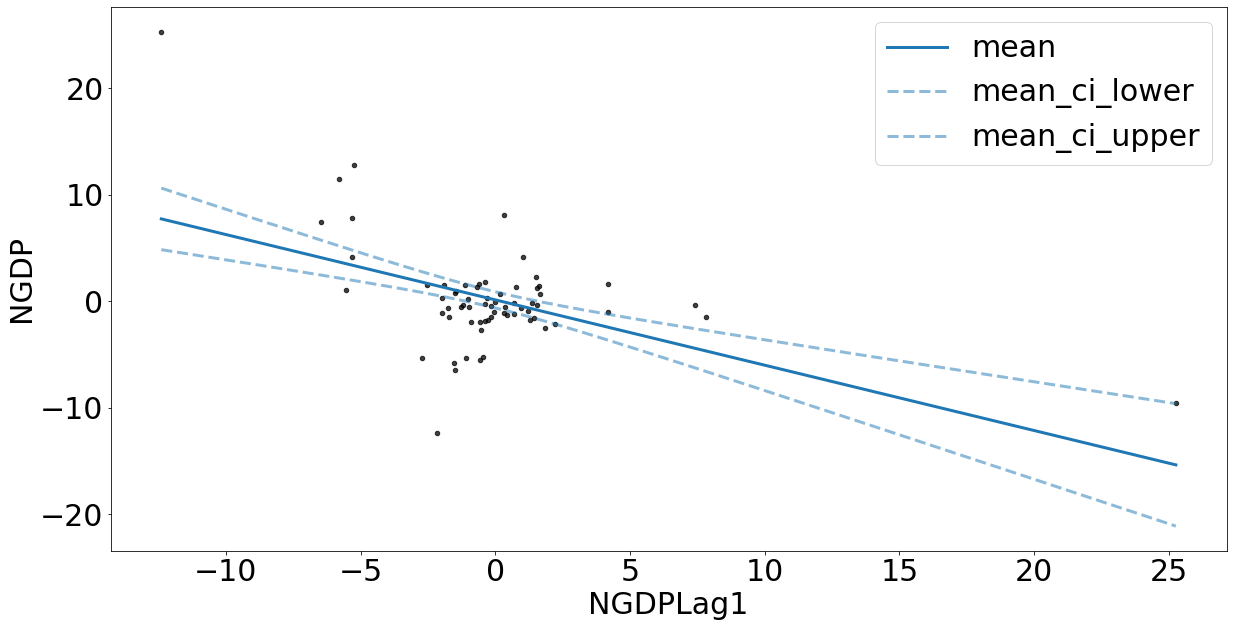

In [10]:
# fig, ax = plt.subplots(figsize = (20,20))
plot_vars = ["NGDP",  "EFFR", "UST10Y", "Currency", "MB","FRAssets"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = annual_rate.diff(freq)[plot_vars].loc["2004":].dropna()
formula = 'NGDP ~  Currency + EFFR + UST10Y + MB + FRAssets'

for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 
        
# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()


In [ ]:
3yma_list = ["a", "b", "c"]
for name in 3yma_list:
    data[name + "_3YMA"] = data[name].rolling(3).mean().shift()